# Machine Learning Project 2022: Plankton

### Authors:
- Bram Fresen
- Bram Huis
- Max Burger
- Moos Middelkoop

For the Machine Learning Project to finish off the minor Artificial Intelligence, we chose to tackle the plankton problem, originally uploaded as the United States national data science bowl in december 2014. For this problem, the goal is to classify microscopic images of particles in water as one of 121 different classes of plankton. The dataset is 30.000 images large, with varying sizes. The dataset is also imbalanced.

In order to solve this problem we will make use of a Convolutional Neural Network using the tensorflow library.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Import libraries

Firstly, we will import the needed libraries, and check if we are running on a GPU.

In [6]:
import tensorflow as tf 
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns

from imblearn.over_sampling import SMOTE
from tensorflow import math as tfmath
from tensorflow.keras import layers, models, preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight

print(tf.config.list_physical_devices('GPU'))

[]


## Loading the training data and training labels

We use the cv2 library to load the training images (which are .jpg files), and turn them into arrays. This piece of code was found online:

https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
https://drive.google.com/file/d/1hAaPzDMVEZ8X1tfRS2ieFEqi0R7Ww7uL/view

### Training data

Training data is sorted into folders by class, this next piece of code reads in the training data, puts it in an array, and constructs an array for the classes by using the names of the folders. At the end, this array for the labels is turned into a one-hot matrix, so that tensorflow can work with it.

We also delete the unnecessary channels here already, all input images consist of 3 channels with exactly the same values, so we drop two of them in order to remove redundant data.

In [7]:
def read_data(folder):
    # Create empty lists for the not resized training data, the labels (not one hot encoded yet) and the class sizes
    train_data = []
    train_labels = []
    class_size_list = []
    categories_list =[]
    offset = 0

    # Loop through the index (for the one hot matrix) and the categories
    for number, categories in enumerate(os.listdir(folder)):
        class_size = 0
        categories_list.append(categories)
        print(number)

        # If we come across a hidden folder (starting with ".") on mac os, we ignore it
        if categories[0] == ".":
            offset += 1
            continue

        # Loop through the images , add 1 to the class size, read the images in in and add them to a list, 
        # also add the index 'number' to a list for the one hot matrix
        for image in os.listdir(f'{folder}/{categories}'):
            class_size += 1
            train_labels.append(number - offset)
            img = cv2.imread(os.path.join(f'{folder}/{categories}', image))
            train_data.append(img[:, :, 0])
      
        # Append the size of the class to the class size list, in order to check the class sizes later, this way we
        # can ananlyze the degree of class imbalance
        class_size_list.append(class_size)

    # Create a one hot matrix from the train labels
    train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=121)
  
    return train_data, train_labels_one_hot, class_size_list, categories_list

train_data, train_labels, class_size_list, categories_list = read_data('data/train')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


# Resize input images

Because all images are differnt sizes, it is necessary to resize all input data to the same size, in order to make tensorflow be able to work with the data. The first cell below analyzes the sizes of the data, and the second cell actually resizes, based on this analysis. An essential element is explicitly adding a third dimension with a value of 1 to the images, otherwise tensorflow can't work with the data. Lastly, the data is converted into numpy arrays, so tensorflow will be able to work with them

Average dimensions: 66.66182093881856, 73.50728507383967
Lowest first dimension image (21, 71)
Lowest second dimension image (31, 49)


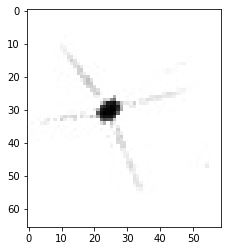

In [8]:
# Start with an infinitely large number
value_1 = math.inf
value_2 = math.inf
sum_1 = 0
sum_2 = 0
count = 0

# This checks for the lowest image size in the first and second dimension
for image in train_data:
    count+=1
    sum_1 += image.shape[0]
    sum_2 += image.shape[1]
    if image.shape[0] < value_1:
        
        value_1 = image.shape[0]
        hold_1 = image.shape
    if image.shape[1] < value_2:
        
        value_2 = image.shape[0]
        hold_2 = image.shape
        
sum_11 = sum_1 / count
sum_22 = sum_2 / count

print(f'Average dimensions: {sum_11}, {sum_22}')

plt.imshow(train_data[0], cmap = 'gray')

print(f'Lowest first dimension image {hold_1}')
print(f'Lowest second dimension image {hold_2}')

## Resizing Function

In the cell below, we define a function that resizes a given image to a dimension given the optimal manner of up- or downscaling. 

(64, 64, 1)


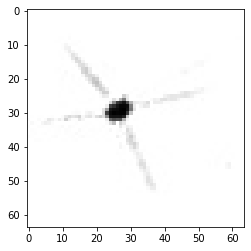

In [9]:
def resizer(image, target_dimension):
    '''
    Takes an image and a desired dimension (tuple), and converts the image given the best interpolation method
    '''

    if len(image[0]) * len(image[1]) > target_dimension[0] * target_dimension[1]:
        rescaled_image = np.expand_dims(cv2.resize(image, dsize = target_dimension, interpolation = cv2.INTER_AREA), axis = 2) 
    else:
        rescaled_image = np.expand_dims(cv2.resize(image, dsize = target_dimension, interpolation = cv2.INTER_CUBIC), axis = 2)        
    return rescaled_image    
    
# Create an empty list for the training data
train_data_resized = []
target_dim = (64, 64)

# Loop through the images in the training data and resize them to desired dimension
for image in train_data:
    train_data_resized.append(resizer(image, target_dim))

# Test if the image is resized and show the image
print(train_data_resized[0].shape)
plt.imshow(train_data_resized[0], cmap = 'gray')

#Split the data into 70% training and 30% validation
im_train, im_val, lab_train, lab_val = train_test_split(train_data_resized, train_labels, train_size=0.7, random_state=1265599650, stratify = train_labels)

In [10]:
# Convert the data to numpy arrays, so tensorflow can use them
image_train = np.array(im_train)
label_train = np.array(lab_train)
image_val = np.array(im_val)
label_val = np.array(lab_val)

# Test if the shapes are correct
print(image_train.shape)
print(label_train.shape)
print(image_val.shape)
print(label_val.shape)

(21235, 64, 64, 1)
(21235, 121)
(9101, 64, 64, 1)
(9101, 121)


## Convolutional network

We use the function 'train_and_evaluate' which, obviously, trains our model and then evaluates the trained model on the validation data. This function was reused from the CIFAR-assignment from module 6 of ML2.

Y_ints line: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [13]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}, decay = True, 
                       initial_learning_rate = 1e-5, learning_rate = 0.00009):
    
    if decay:
        print("Learning rate decay is ON")
        
        
        # Define a learning rate schedule
        optimizer = tf.keras.optimizers.SGD(lr=initial_learning_rate, momentum= 0.9, decay= initial_learning_rate/epochs, nesterov=False)
        
    
    else:
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
        print(f"Learning rate decay is OFF. Learning rate is {learning_rate}")
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)
    
    # used for k-fold
    y_ints = [y.argmax() for y in label_train]
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_ints), y = y_ints)
    
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")
    return model.evaluate(val_gen.flow(val_x, val_y))[1]

## The actual model

We start with a very simple convolutional neural network, with 2 convolutional layers, both with pooling afterwards, and one dense layer. kernelsize, amount of filters, amount of nodes are specified in the code cell. This first version of the model gives us a validation accuracy of approximately 64%

In [14]:
def build_model(first_layer_filters = 32, second_layer_filters = 64, third_layer_filters = 128,fourth_layer_filters = 128, 
                kernelsize = (3,3), inputshape = (64, 64, 1), first_hidden_layer_nodes = 1024, second_hidden_layer_nodes = 512, 
                pooling_size = (2,2), activation = layers.LeakyReLU(alpha= 0.15)):
    
    """
    Function that builds a sequential model with the given architecture
    """
    output_nodes = 121
    
    model_1 = models.Sequential()

    model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = activation, padding = 'same', input_shape = inputshape))
    model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = activation, padding = 'same'))
    model_1.add(layers.MaxPooling2D(pooling_size))
    model_1.add(layers.Dropout(0.5))
    
    model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = activation, padding = 'same'))
    model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = activation, padding = 'same'))
    model_1.add(layers.MaxPooling2D(pooling_size))
    model_1.add(layers.Dropout(0.5))
    
    model_1.add(layers.Conv2D(third_layer_filters, kernelsize, activation = activation, padding = 'same'))
    model_1.add(layers.Conv2D(third_layer_filters, kernelsize, activation = activation, padding = 'same'))
    model_1.add(layers.MaxPooling2D(pooling_size))
    model_1.add(layers.Dropout(0.5))
    
    model_1.add(layers.Conv2D(fourth_layer_filters, kernelsize, activation = activation, padding = 'same'))
    model_1.add(layers.Conv2D(fourth_layer_filters, kernelsize, activation = activation, padding = 'same'))
    model_1.add(layers.MaxPooling2D(pooling_size))
    model_1.add(layers.Dropout(0.5))
    
    model_1.add(layers.Flatten())

    model_1.add(layers.Dense(first_hidden_layer_nodes, activation = activation))
    model_1.add(layers.Dropout(0.5))
    model_1.add(layers.Dense(second_hidden_layer_nodes, activation = activation))
    model_1.add(layers.Dropout(0.5))
    model_1.add(layers.Dense(output_nodes, activation = 'softmax'))
    
    return model_1

model_1 = build_model()

train_and_evaluate(model_1, image_train, label_train, image_val, label_val, epochs = 10)

Learning rate decay is ON


NameError: name 'inital_learning_rate' is not defined

In [ ]:
model_1.summary()


## Different resizing 

In [ ]:
# Filter out the largest example (and possibily the second-largest) to illustrate resizing
storage_1 = 0 
storage_2 = 0
store_img1 = None
store_img2 = None
for image in train_data:
    store = image.shape[0]
    if store > storage_1 and store > storage_2:
        store_img1 = image
        storage_1 = image.shape[0]
    if store > storage_2 and store != storage_1:
        store_img2 = image
        storage_2 = image.shape[0]
        

# Plot the different manners of interpolation for comparison
f, axarr = plt.subplots(2,3, figsize=(12, 12))
axarr[0,0].imshow(store_img1, cmap = 'gray')
axarr[0,0].set_title('Original picture:')
axarr[1,0].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_LINEAR), cmap = 'gray')
axarr[1,0].set_title('Bilinear interpolation:')
axarr[0,1].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_AREA), cmap = 'gray')
axarr[0,1].set_title('Pixel area relation interpolation:')
axarr[1,1].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_NEAREST), cmap = 'gray')
axarr[1,1].set_title('Nearest-neighbor interpolation:')
axarr[0,2].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_CUBIC), cmap = 'gray')
axarr[0,2].set_title('Bicubic interpolation:')
axarr[1,2].imshow(cv2.resize(store_img1, dsize = (32, 32), interpolation = cv2.INTER_LANCZOS4), cmap = 'gray')
axarr[1,2].set_title('Lanczos interpolation:')

#plt.savefig('resizingmethods.png')

In [ ]:
# First compute the predictions based on the trained model
y_pred = tf.keras.utils.to_categorical(model_1.predict_classes(image_val))


# Convert both actual and predict to utilize in conf matrix 
y_true = tf.argmax(label_val, axis=1)
y_pred = tf.argmax(y_pred, axis=1)

# Compute matrix
conf_matrix = tfmath.confusion_matrix(y_true, y_pred)

# Remove the diagonal for clearer image
cnf_mtrx = np.array(conf_matrix)
np.fill_diagonal(cnf_mtrx, 0)

# Save this version for usage with SMOTE
smote_conf_matr = np.copy(cnf_mtrx)

# Compute heatmap for abosulte numbers

plt.figure(figsize=(60,60))
ax = sns.heatmap(cnf_mtrx, annot=True, fmt="d", xticklabels=categories_list, yticklabels=categories_list)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

# Compute the relative (%) cf matrix and corresponding heatmap

cnf_mtrx = np.nan_to_num((cnf_mtrx / cnf_mtrx.astype(np.float).sum()), copy=True, nan=0.0, posinf=None, neginf=None)
plt.figure(figsize=(60,60))
ax = sns.heatmap(cnf_mtrx, annot=True, xticklabels=categories_list, yticklabels=categories_list)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')

plt.show()

## Stratified K-folds

In the cell below, we can train the model in K stratified folds, meaning we can test the model over different test and train splits that take the distribution of classes into account when making said splits.

In [ ]:
# Convert data to array before split to use in stratified kfolds
all_image = np.array(train_data_resized)
all_labels = np.array(train_labels)

# Convert one hot matrix back to label vector
y_ints_all = [y.argmax() for y in all_labels]
y_ints_all = np.array(y_ints_all)


def stratified_kfold(n_splits = 2):
    """
    Function that trains and evaluates the model on K stratified train test splits
    """
    
    # Define stratified kfold and number of splits
    skf = StratifiedKFold(n_splits = n_splits)
    skf.get_n_splits(all_image, all_labels)

    val_accuracy_list = []

    # Iterate over the splits
    for train_index, test_index in skf.split(all_image, y_ints_all):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = all_image[train_index], all_image[test_index]
        y_train, y_test = all_labels[train_index], all_labels[test_index]

        model_1 = build_model()

        # Call train and evaluate for every split
        val_accuracy = train_and_evaluate(model_1, X_train, y_train, X_test, y_test, epochs = 10)
        val_accuracy_list.append(val_accuracy)
    
    # Print the mean accuracies
    print("------------------------------------------------------------------")
    print(f"The mean accuracy of {n_splits} folds is {np.mean(val_accuracy_list)}")

stratified_kfold()

## SMOTE
In the cell below, we oversample the minority classes in the training data to try and combat the data imbalance. We can try and adjust the parameters of the smote to set a limit to which classes get oversampled. This is important as it may be ineffective to oversample the smallest classes. 
    

In [ ]:
print(smote_conf_matr)
def conf_smote_dict(smote_conf_matr, min_errors, smote_value, max_smote_value = 1385, min_smote_value = 400):
    smote_dict = {}
    j = 0
    for pred in smote_conf_matr:
        error_classes = list(np.where(pred >= min_errors)[0])
        error_values = pred[pred>= min_errors]
        if len(error_classes) > 0:
                actual_class = j
                smote_dict[actual_class] = np.clip(sum(error_values) * 2, min_smote_value, max_smote_value)
        for i in range(len(error_classes)):
            smote_dict[error_classes[i]] = np.clip(error_values[i] * 4, min_smote_value, max_smote_value)
        j += 1
    return smote_dict

conf_smote_dict = conf_smote_dict(smote_conf_matr, 100, 800)
print(conf_smote_dict)

In [ ]:
def smote_dict(class_size_list, label_train, smote_size = 1385, smallest_oversample = 45):
    one_hot_list = np.unique(label_train, axis = 0)
    int_list = [y.argmax() for y in one_hot_list]
    smote_dict = {}
    
    for i in range(len(int_list)):
        if class_size_list[i] > smallest_oversample:
            smote_dict[int_list[i]] = smote_size
        
    return smote_dict

smote_dict = smote_dict(class_size_list, label_train)


In [ ]:
def smote_data(image_train, smote_dict, k = 4):
    """
    Function that oversamples the minority classes of the given data based on K neighbors
    """
    # Convert labels into ints
    y_ints = [y.argmax() for y in label_train]
    
    # Get shape of the train data
    nsamples, nx, ny, nz = image_train.shape

    # Create two dimensional traindata
    d2_train_dataset = image_train.reshape((nsamples, nx * ny * nz))

    # Define smote for minority classes
    smote = SMOTE(sampling_strategy = smote_dict, k_neighbors = k)

    # Apply smote to our 2 dim traning data
    X_smote, y_smote = smote.fit_resample(d2_train_dataset , y_ints)

    # Convert labels back to one hot
    y_smote = tf.keras.utils.to_categorical(y_smote, num_classes=121)
    
    # Print the new shape to see how this affected the data
    print(f"The shape of X after smote is: {X_smote.shape}, the shape of y after smote is: {y_smote.shape}")

    # Reshape the smote data into the original format
    smoted_train = X_smote.reshape((X_smote.shape[0], nx, ny, nz))

    # Check the shapes
    print(f"The shape of X after smote and reshaping is {smoted_train.shape}")
    
    return smoted_train, y_smote

smoted_train, y_smote = smote_data(image_train, smote_dict)

In [3]:
def decayed_learning_rate(step, initial_learning_rate = 0.001, decay_rate = 1, decay_steps = 10000):
  return initial_learning_rate * decay_rate ** (step / decay_steps)

print(decayed_learning_rate(100))

0.001
